# # Generate Figure 3
The catalytic role of NMDA nonlinearities in the creation of stable states. A. Removing the NMDA synaptic conductance and compensating by increasing AMPA conductance, results in loss of both the non-linear jump and the depolarizing plateau, for increasing synaptic drive. B. Same as A, but now after removal of the Mg blockage component (see Methods) only the non-linear jump is removed, with the depolarizing plateau retained. C. Removing either the non-linear jump or the depolarizing plateau from the network excitatory connections, eliminates  WM state space stable states number. D. This reduced states number is also produced if the structured connection configuration is replaced by a random one. 

Import necessary modules:

In [1]:
import notebook_module as nb
import analysis_tools as analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from pathlib import Path
from pynwb import NWBHDF5IO
from itertools import chain
import matplotlib.gridspec as gridspec

## Create figure 2

determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 3
Cannot run kmeans with greater k than the data_pcapoints!
@k:3 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 4
Cannot run kmeans with greater k than the data_pcapoints!
@k:5 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:4 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 1
Cannot run kmeans with greater k than the data_pcapoints!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 3
Cannot run kmeans with greater k than the data_pcapoints!
@k:3 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:2 k_means Overfit!!!
determine_number

determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:3 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:2 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 3
Cannot run kmeans with greater k than the data_pcapoints!
@k:4 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 3
Cannot run kmeans with greater k than the data_pcapoints!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:4 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
determine_number_of_clusters reseeds the

determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
@k:2 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
@k:2 k_means Overfit!!!
Got Exception during analysis Unable to open file (unable to open file: name = 'C:\Users\steve\Documents\analysis\Python\simulations\animal_model_4_learning_condition_6_bn_structured_nonmda.nwb', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Got Exception during analysis Unable to open file (unable to open file: name = 'C:\Users\steve\Documents\analysis\Python\simulations\animal_model_4_learning_condition_7_bn_structured_nonmda.nwb', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Got Exception during analysis Unable to open file (unable to open file: name = 'C:\Users\steve\Documents\analysis\Python\simulations\animal_model_4_learning_condition_8_bn_structured_nonmda.nwb', errno = 2, error message = 'No s

determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:2 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:4 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 3
Cannot run kmeans with greater k than the data_pcapoints!
@k:3 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
Cannot run kmeans with greater k than the data_pcapoints!
@k:4 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 1
@k:2 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
@k:7 k_means Overfit!!!
determine_number_of_clusters reseeds the RNG.
pcaL2 reseeds the RNG.
L found to be: 2
@k:3 k_means Overfit!!

c:\users\steve\anaconda3\envs\publication\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


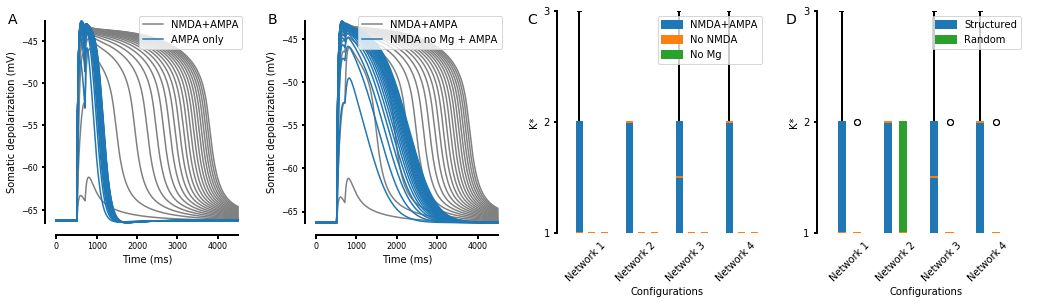

In [2]:
simulations_dir = Path.cwd().joinpath('simulations')
glia_dir = Path(r'G:\Glia')
plt.rcParams.update({'font.family': 'Helvetica'})
plt.rcParams["figure.figsize"] = (15, 15)

y_array = np.linspace(0.1, 100, 1000)
y_i = 500
# FIGURE 3 A, B
subplot_width = 4
subplot_height = 1
figure3 = plt.figure(figsize=plt.figaspect(subplot_height / subplot_width))
figure3_axis = np.zeros((subplot_height, subplot_width), dtype=object)

# Figure 3A:
A_axis = figure3.add_subplot(
    subplot_height, subplot_width, 1
)

# Lazy load the data as a NWB file.
input_NWBfile = simulations_dir.joinpath('excitatory_validation.nwb')
nwbfile = NWBHDF5IO(str(input_NWBfile), 'r').read()
per_trial_activity = {}
per_trial_activity['normal_NMDA+AMPA'] = analysis.separate_trials(
    input_NWBfile=nwbfile, acquisition_name='normal_NMDA+AMPA'
)
per_trial_activity['normal_AMPA_only'] = analysis.separate_trials(
    input_NWBfile=nwbfile, acquisition_name='normal_AMPA_only'
)
per_trial_activity['noMg_NMDA+AMPA'] = analysis.separate_trials(
    input_NWBfile=nwbfile, acquisition_name='noMg_NMDA+AMPA'
)

for trace in per_trial_activity['normal_NMDA+AMPA']:
    nmda_ampa_plot = A_axis.plot(trace[0][500:5000], color='gray', label='NMDA+AMPA')
for trace in per_trial_activity['normal_AMPA_only']:
    ampa_only_plot = A_axis.plot(trace[0][500:5000], color='C0', label='AMPA only')
A_axis.set_xlabel('Time (ms)')
A_axis.set_ylabel('Somatic depolarization (mV)')
A_axis.legend((nmda_ampa_plot[0], ampa_only_plot[0]), ['NMDA+AMPA', 'AMPA only'], loc='upper right')
nb.axis_normal_plot(A_axis)
nb.adjust_spines(A_axis, ['left', 'bottom'], blowout=2)
nb.mark_figure_letter(A_axis, 'A')

# Figure 3B:
B_axis = figure3.add_subplot(
    subplot_height, subplot_width, 2
)
nb.mark_figure_letter(B_axis, 'B')
for trace in per_trial_activity['normal_NMDA+AMPA']:
    nmda_ampa_plot = B_axis.plot(trace[0][500:5000], color='gray', label='NMDA+AMPA')
for trace in per_trial_activity['noMg_NMDA+AMPA']:
    nmda_nomg_plot = B_axis.plot(trace[0][500:5000], color='C0', label='NMDA no Mg + AMPA')
B_axis.set_xlabel('Time (ms)')
B_axis.set_ylabel('Somatic depolarization (mV)')
B_axis.legend((nmda_ampa_plot[0], nmda_nomg_plot[0]), ['NMDA+AMPA', 'NMDA no Mg + AMPA'], loc='upper right')
nb.axis_normal_plot(B_axis)
nb.adjust_spines(B_axis, ['left', 'bottom'], blowout=2)


# FIGURE 3C:

# Plot what happens with no NMDA, no Mg:
no_of_conditions = 10
no_of_animals = 4
optimal_clusters_of_group = defaultdict(partial(np.ndarray, 0))
configurations = ['structured', 'structured_nonmda', 'structured_nomg']
for animal_model in range(1, no_of_animals + 1):
    # Pool together no of clusters for one animal model:
    K_star_over_trials = np.ones((no_of_conditions, len(configurations)))
    for config_id, config in enumerate(configurations):
        for learning_condition in range(1, no_of_conditions + 1):
            try:
                # Lazy load the data as a NWB file. Easy to pass around and encapsulates info like trial length, stim times etc.
                NWBfile = analysis.load_nwb_file(
                    animal_model=animal_model,
                    learning_condition=learning_condition,
                    experiment_config=config,
                    type='bn',
                    data_path=simulations_dir
                )

                #analysis.bin_activity(nwbfile, q_size=50)

                trial_len = analysis.get_acquisition_parameters(
                    input_NWBfile=NWBfile,
                    requested_parameters=['trial_len']
                )
                custom_range = (20, int(trial_len / 50))


                # Determine the optimal number of clusters for all trials of a single animal
                # model/learning condition.
                K_star, K_labels, *_ = analysis.determine_number_of_clusters(
                    NWBfile_array=[NWBfile],
                    max_clusters=10,
                    y_array=y_array,
                    custom_range=custom_range
                )

                K_star_over_trials[learning_condition - 1, config_id] =                     K_star[y_i]
            except Exception as e:
                print(f'Got Exception during analysis {str(e)}')

    optimal_clusters_of_group[f'Network {animal_model}'] =         K_star_over_trials

C_axis = figure3.add_subplot(
    subplot_height, subplot_width, 3
)
max_y = 0
for k_star_trials in optimal_clusters_of_group.values():
    if max_y < k_star_trials.max():
        max_y = k_star_trials.max()

ylim = (1, max_y)
C_axis.set_ylim(ylim[0], ylim[1])

#C_axis.set_title('Optimal no of clusters per configuration')
positions = [
    (position[0], position[0] + 1, position[0] + 2)
    for position in analysis.generate_slices(
        size=4, number=no_of_animals,
        start_from=1, to_slice=False
    )
]
bplots = []
for animal, (pos_a, pos_b, pos_c) in zip(range(1, no_of_animals + 1), positions):
    bp = C_axis.boxplot(
        optimal_clusters_of_group[f'Network {animal}'],
        positions=[pos_a, pos_b, pos_c],
        widths=0.4,
        patch_artist=True,
        labels=configurations
    )
    bplots.append(bp)

nb.setBoxAttribtes(boxplot_handles=bplots, colors=['C0', 'C1', 'C2'])
C_axis.set_xlim(0, 16)
C_axis.set_xticks([
    p + 0.5
    for p, *_ in positions
])
#TODO: this i is not evaluated as I whould expect!
C_axis.set_xticklabels([
    f'Network {i}'
    for i in range(1, no_of_animals + 1)
])
C_axis.set_xlabel('Configurations')
C_axis.set_ylabel('K*')
C_axis.set_yticks(list(range(1, int(max_y) + 1)))
for tick in C_axis.get_xticklabels():
    tick.set_rotation(45)

C_axis.legend(
    [bplots[0]['boxes'][0], bplots[0]['boxes'][1], bplots[0]['boxes'][2]], \
    ['NMDA+AMPA', 'No NMDA', 'No Mg'], loc='upper right'
)
nb.axis_box_plot(C_axis)
nb.adjust_spines(C_axis, ['left'])
nb.mark_figure_letter(C_axis, 'C')


# Figure 3D:
optimal_clusters_of_group = defaultdict(partial(np.ndarray, 0))
configurations = ['structured', 'random']
for animal_model in range(1, no_of_animals + 1):
    # Pool together no of clusters for one animal model:
    K_star_over_trials = np.ones((no_of_conditions, len(configurations)))
    for config_id, config in enumerate(configurations):
        for learning_condition in range(1, no_of_conditions + 1):
            try:
                # Lazy load the data as a NWB file. Easy to pass around and encapsulates info like trial length, stim times etc.
                NWBfile = analysis.load_nwb_file(
                    animal_model=animal_model,
                    learning_condition=learning_condition,
                    experiment_config=config,
                    type='bn',
                    data_path=simulations_dir
                )

                #analysis.bin_activity(nwbfile, q_size=50)

                trial_len = analysis.get_acquisition_parameters(
                    input_NWBfile=NWBfile,
                    requested_parameters=['trial_len']
                )
                custom_range = (20, int(trial_len / 50))


                # Determine the optimal number of clusters for all trials of a single animal
                # model/learning condition.
                K_star, K_labels, *_ = analysis.determine_number_of_clusters(
                    NWBfile_array=[NWBfile],
                    max_clusters=10,
                    y_array=y_array,
                    custom_range=custom_range
                )

                K_star_over_trials[learning_condition - 1, config_id] =                     K_star[y_i]
            except Exception as e:
                print(f'Got Exception during analysis {str(e)}')

    optimal_clusters_of_group[f'Network {animal_model}'] =         K_star_over_trials


D_axis = figure3.add_subplot(
    subplot_height, subplot_width, 4
)
#D_axis.set_title('Optimal no of clusters per configuration')
positions = [
    (position[0], position[0] + 1)
    for position in analysis.generate_slices(
        size=3, number=no_of_animals,
        start_from=1, to_slice=False
    )
]
bplots = []
for animal, (pos_a, pos_b) in zip(range(1, no_of_animals + 1), positions):
    bp = D_axis.boxplot(
        optimal_clusters_of_group[f'Network {animal}'],
        positions=[pos_a, pos_b],
        widths=0.4,
        patch_artist=True,
        labels=configurations
    )
    '''
    if is_significant(optimal_clusters_of_group[datasetName(animal)]):
        statisticalAnnotation(
            columns=(pos_a, pos_b),
            datamax=optimal_clusters_of_group[datasetName(animal)].max(),
            axobj=ax1
        )
    '''
    bplots.append(bp)
nb.setBoxAttribtes(boxplot_handles=bplots, colors=['C0', 'C2'])
D_axis.set_xlim(0, 13)
D_axis.set_xticks([
    p + 0.5
    for p, _ in positions
])
D_axis.set_xticklabels([
    f'Network {i}'
    for i in range(1, no_of_animals + 1)
])
D_axis.set_xlabel('Configurations')
D_axis.set_ylabel('K*')
D_axis.set_yticks(list(range(1, int(max_y) + 1)))
for tick in D_axis.get_xticklabels():
    tick.set_rotation(45)

D_axis.legend([bplots[0]['boxes'][0], bplots[0]['boxes'][1]], ['Structured', 'Random'], loc='upper right')

max_y = 0
for k_star_trials in optimal_clusters_of_group.values():
    if max_y < k_star_trials.max():
        max_y = k_star_trials.max()

ylim = (1, max_y)
D_axis.set_ylim(ylim[0], ylim[1])

nb.axis_box_plot(D_axis)
nb.adjust_spines(D_axis, ['left'])
nb.mark_figure_letter(D_axis, 'D')

plt.subplots_adjust(top=0.92, bottom=0.15, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.30)

plt.show()

In [ ]:
figure3.savefig('Figure_3.png')
figure3.savefig('Figure_3.svg')
print('Tutto pronto!')


#%%